<a href="https://colab.research.google.com/github/vasiliyeskin/MachineLearningExperiences/blob/master/SOTA/Image%20Captioning/SocraticModels_ImageCaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2021 Google LLC.
SPDX-License-Identifier: Apache-2.0

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# **Socratic Models: Image Captioning**

Socratic Models (SMs) is a framework that composes multiple pre-existing foundation models (e.g., large language models, visual language models, audio-language models) to provide results for new multimodal tasks, without any model finetuning.

This colab runs an example of SMs for image captioning.

This is a reference implementation of one task demonstrated in the work: [Socratic Models: Composing Zero-Shot Multimodal Reasoning with Language](https://socraticmodels.github.io/)

**Disclaimer:** this colab uses CLIP and GPT-3 as foundation models, and may be subject to unwanted biases. This code should be used with caution (and checked for correctness) in downstream applications.

### **Quick Start:**

**Step 1.** Register for an [OpenAI API key](https://openai.com/blog/openai-api/) to use GPT-3 (there's a free trial) and enter it below

**Step 2.** Menu > Change runtime type > Hardware accelerator > "GPU"

**Step 3.** Menu > Runtime > Run all



In [6]:
openai_api_key = "your-api-key"

## **Setup**
This installs a few dependencies: PyTorch, CLIP, GPT-3.

In [7]:
!pip install ftfy regex tqdm fvcore imageio imageio-ffmpeg openai pattern
!pip install git+https://github.com/openai/CLIP.git
!pip install -U --no-cache-dir gdown --pre
# !pip install spacy==3.4.0
!pip install profanity-filter
!nvidia-smi  # Show GPU info.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-kwc82rm8
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-kwc82rm8
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mon Aug 22 09:13:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
| 

In [8]:
! free -h

              total        used        free      shared  buff/cache   available
Mem:            12G         10G        170M         13M        2.3G          9G
Swap:            0B          0B          0B


In [ ]:
# # as you can see current ram is 12GB only, to increase it run below code
# i = []
# while True:
#   i.append(i)

#   # wait for few minutes, after that you will get a prompt that your notebook got crashed, do you want to increase ram ?
#   # in the prompt click - yes
#   # as you see the ram increase from 12GB to 25GB
#   # thanks for watching, keep learning
#   # lifehack from https://colab.research.google.com/drive/155S_bb3viIoL0wAwkIyr1r8XQu4ARwA9?usp=sharing#scrollTo=XryjXIYhQ_gM

In [9]:
import datetime
import json
import os
import re
import time

import requests
import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import openai
from PIL import Image
from profanity_filter import ProfanityFilter
import torch

openai.api_key = openai_api_key

### **GPT-neo**

In [ ]:
! pip install transformers

In [ ]:
# from transformers import pipeline
# generator = pipeline('text-generation', model='EleutherAI/gpt-neo-125M')
# generated_text = generator("EleutherAI has", do_sample=True, min_length=10)
# print(generated_text)

In [ ]:
# print(generated_text[0]['generated_text'])

In [ ]:
from transformers import GPTNeoForCausalLM, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
model_neo = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B")

# tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
# model_neo = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-125M", pad_token_id=tokenizer.eos_token_id)

model_neo.cuda().eval()

In [3]:
prompt = (
    "In a shocking finding, scientists discovered a herd of unicorns living in a remote, "
    "previously unexplored valley, in the Andes Mountains. Even more surprising to the "
    "researchers was the fact that the unicorns spoke perfect English."
)

input_ids = tokenizer(prompt, return_tensors="pt").input_ids

gen_tokens = model_neo.generate(
    input_ids.cuda(),
    do_sample=True,
    temperature=0.9,
    pad_token_id=tokenizer.eos_token_id,
    max_length=64,
)
gen_text = tokenizer.batch_decode(gen_tokens)[0]
print(gen_text.strip())
print(gen_text[len(prompt):].strip())

In a shocking finding, scientists discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English. The story was written up for The Huffington Post, and it is also a YouTube clip for the
The story was written up for The Huffington Post, and it is also a YouTube clip for the


## **Foundation Models**
Select which foundation models to use.

**Defaults:** [CLIP](https://arxiv.org/abs/2103.00020) VIT-L/14 as the VLM, and [GPT-3](https://arxiv.org/abs/2005.14165) "Davinci" as the LM.

In [10]:
clip_version = "ViT-L/14" #@param ["RN50", "RN101", "RN50x4", "RN50x16", "RN50x64", "ViT-B/32", "ViT-B/16", "ViT-L/14"] {type:"string"}
gpt_version = "text-davinci-002" #@param ["text-davinci-001", "text-davinci-002", "text-curie-001", "text-babbage-001", "text-ada-001"] {type:"string"}

clip_feat_dim = {'RN50': 1024, 'RN101': 512, 'RN50x4': 640, 'RN50x16': 768, 'RN50x64': 1024, 'ViT-B/32': 512, 'ViT-B/16': 512, 'ViT-L/14': 768}[clip_version]

## **Getting Started**
Download CLIP model weights, and define helper functions. This might take a few minutes.

##### Download [CLIP](https://arxiv.org/abs/2103.00020) model weights.

In [11]:
# torch.cuda.set_per_process_memory_fraction(0.9, None)  # Only needed if session crashes.
model, preprocess = clip.load(clip_version)  # clip.available_models()
model.cuda().eval()

def num_params(model):
  return np.sum([int(np.prod(p.shape)) for p in model.parameters()])
print("Model parameters (total):", num_params(model))
print("Model parameters (image encoder):", num_params(model.visual))
print("Model parameters (text encoder):", num_params(model.token_embedding) + num_params(model.transformer))
print("Input image resolution:", model.visual.input_resolution)
print("Context length:", model.context_length)
print("Vocab size:", model.vocab_size)
img_size = model.visual.input_resolution

Model parameters (total): 427616513
Model parameters (image encoder): 303966208
Model parameters (text encoder): 122999808
Input image resolution: 224
Context length: 77
Vocab size: 49408


##### Define CLIP helper functions (e.g., nearest neighbor search).

In [12]:
def get_text_feats(in_text, batch_size=64):
  text_tokens = clip.tokenize(in_text).cuda()
  text_id = 0
  text_feats = np.zeros((len(in_text), clip_feat_dim), dtype=np.float32)
  while text_id < len(text_tokens):  # Batched inference.
    batch_size = min(len(in_text) - text_id, batch_size)
    text_batch = text_tokens[text_id:text_id+batch_size]
    with torch.no_grad():
      batch_feats = model.encode_text(text_batch).float()
    batch_feats /= batch_feats.norm(dim=-1, keepdim=True)
    batch_feats = np.float32(batch_feats.cpu())
    text_feats[text_id:text_id+batch_size, :] = batch_feats
    text_id += batch_size
  return text_feats

def get_img_feats(img):
  img_pil = Image.fromarray(np.uint8(img))
  img_in = preprocess(img_pil)[None, ...]
  with torch.no_grad():
    img_feats = model.encode_image(img_in.cuda()).float()
  img_feats /= img_feats.norm(dim=-1, keepdim=True)
  img_feats = np.float32(img_feats.cpu())
  return img_feats

def get_nn_text(raw_texts, text_feats, img_feats):
  scores = text_feats @ img_feats.T
  scores = scores.squeeze()
  high_to_low_ids = np.argsort(scores).squeeze()[::-1]
  high_to_low_texts = [raw_texts[i] for i in high_to_low_ids]
  high_to_low_scores = np.sort(scores).squeeze()[::-1]
  return high_to_low_texts, high_to_low_scores

##### Define [GPT-3](https://arxiv.org/abs/2005.14165) helper functions.

In [ ]:
def prompt_llm(prompt, max_tokens=64, temperature=0, stop=None):
  response = openai.Completion.create(engine=gpt_version, prompt=prompt, max_tokens=max_tokens, temperature=temperature, stop=stop)
  return response["choices"][0]["text"].strip()

##### Define **GPT-neo** helper functions.

In [20]:
def prompt_llm_gptneo(prompt, max_tokens=64, temperature=0, stop=None):
  input_ids = tokenizer(prompt, return_tensors="pt").input_ids

  gen_tokens = model_neo.generate(
      input_ids.cuda(),
      do_sample=True,
      top_p=1,
      temperature=temperature,
      pad_token_id=tokenizer.eos_token_id,
      max_new_tokens=max_tokens,
  )
  gen_text = tokenizer.batch_decode(gen_tokens)[0]

  return gen_text[len(prompt):].strip()

##### Load scene categories from [Places365](http://places2.csail.mit.edu/download.html) and compute their CLIP features.

In [14]:
# Load scene categories from Places365.
if not os.path.exists('categories_places365.txt'):
  ! wget https://raw.githubusercontent.com/zhoubolei/places_devkit/master/categories_places365.txt
place_categories = np.loadtxt('categories_places365.txt', dtype=str)
place_texts = []
for place in place_categories[:, 0]:
  place = place.split('/')[2:]
  if len(place) > 1:
    place = place[1] + ' ' + place[0]
  else:
    place = place[0]
  place = place.replace('_', ' ')
  place_texts.append(place)
place_feats = get_text_feats([f'Photo of a {p}.' for p in place_texts])

##### Load object categories from [Tencent ML Images](https://arxiv.org/pdf/1901.01703.pdf) and compute their CLIP features. This might take a few minutes.

In [17]:
# ! pip install spacy==3.2.0

In [15]:
! python -m spacy download en

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached en_core_web_sm-2.3.1-py3-none-any.whl
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [16]:
# Load object categories from Tencent ML Images.
if not os.path.exists('dictionary_and_semantic_hierarchy.txt'):
  ! wget https://raw.githubusercontent.com/Tencent/tencent-ml-images/master/data/dictionary_and_semantic_hierarchy.txt
with open('dictionary_and_semantic_hierarchy.txt') as fid:
    object_categories = fid.readlines()
object_texts = []
pf = ProfanityFilter()
for object_text in object_categories[1:]:
  object_text = object_text.strip()
  object_text = object_text.split('\t')[3]
  safe_list = ''
  for variant in object_text.split(','):
    text = variant.strip()
    if pf.is_clean(text):
      safe_list += f'{text}, '
  safe_list = safe_list[:-2]
  if len(safe_list) > 0:
    object_texts.append(safe_list)
object_texts = [o for o in list(set(object_texts)) if o not in place_texts]  # Remove redundant categories.
object_feats = get_text_feats([f'Photo of a {o}.' for o in object_texts])

## **Demo:** Image Captioning
Run image captioning on an Internet image (linked via URL).

**Note:** due to the non-zero temperature used for sampling from the generative language model, results from this approach are stochastic, but comparable results are producible.



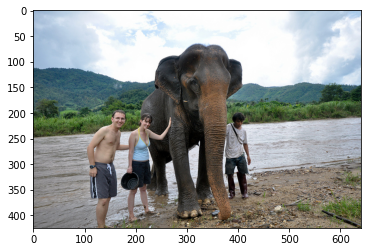

"A photo of a young female Lao elephant with a tourist from Switzerland."

I am an intelligent image captioning bot.
This image is a photo. There are three people.
I think this photo was taken at a watering hole, outdoor hotel, or rope bridge.
I think there might be

VLM: This image is a:
0.1519 photo
0.1280 sketch
0.0905 cartoon
0.0900 painting

VLM: There:
0.1604 are three people
0.1560 are two people
0.1508 are many people
0.1485 is one person
0.1472 are several people

VLM: I think this photo was taken at a:
0.1813 watering hole
0.1549 outdoor hotel
0.1541 rope bridge

VLM: I think there might be a:
0.2174 elephant
0.2132 animal trainer, handler
0.2115 pachyderm
0.2107 fieldwork
0.2092 guide
0.2059 Bornean
0.2031 female mammal
0.2029 tourist, tourer, holidaymaker
0.1994 Indian elephant, Elephas maximus
0.1991 Lao, Laotian

LM generated captions ranked by VLM scores:
0.2957 "A photo of a young female Lao elephant with a tourist from Switzerland."

I am an intelligent image captionin

In [31]:
# Download image.
img_url = "https://github.com/rmokady/CLIP_prefix_caption/raw/main/Images/COCO_val2014_000000165547.jpg" #@param {type:"string"}
img_url = "https://github.com/rmokady/CLIP_prefix_caption/raw/main/Images/COCO_val2014_000000354533.jpg"
img_url = "https://github.com/rmokady/CLIP_prefix_caption/raw/main/Images/COCO_val2014_000000562207.jpg"
fname = 'demo_img.png'
with open(fname, 'wb') as f:
    f.write(requests.get(img_url).content)

verbose = True #@param {type:"boolean"}

# Load image.
img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
img_feats = get_img_feats(img)
plt.imshow(img); plt.show()

# Zero-shot VLM: classify image type.
img_types = ['photo', 'cartoon', 'sketch', 'painting']
img_types_feats = get_text_feats([f'This is a {t}.' for t in img_types])
sorted_img_types, img_type_scores = get_nn_text(img_types, img_types_feats, img_feats)
img_type = sorted_img_types[0]

# Zero-shot VLM: classify number of people.
ppl_texts = ['no people', 'people']
ppl_feats = get_text_feats([f'There are {p} in this photo.' for p in ppl_texts])
sorted_ppl_texts, ppl_scores = get_nn_text(ppl_texts, ppl_feats, img_feats)
ppl_result = sorted_ppl_texts[0]
if ppl_result == 'people':
  ppl_texts = ['is one person', 'are two people', 'are three people', 'are several people', 'are many people']
  ppl_feats = get_text_feats([f'There {p} in this photo.' for p in ppl_texts])
  sorted_ppl_texts, ppl_scores = get_nn_text(ppl_texts, ppl_feats, img_feats)
  ppl_result = sorted_ppl_texts[0]
else:
  ppl_result = f'are {ppl_result}'

# Zero-shot VLM: classify places.
place_topk = 3
place_feats = get_text_feats([f'Photo of a {p}.' for p in place_texts ])
sorted_places, places_scores = get_nn_text(place_texts, place_feats, img_feats)

# Zero-shot VLM: classify objects.
obj_topk = 10
sorted_obj_texts, obj_scores = get_nn_text(object_texts, object_feats, img_feats)
object_list = ''
for i in range(obj_topk):
  object_list += f'{sorted_obj_texts[i]}, '
object_list = object_list[:-2]

# Zero-shot LM: generate captions.
num_captions = 10
prompt = f'''I am an intelligent image captioning bot.
This image is a {img_type}. There {ppl_result}.
I think this photo was taken at a {sorted_places[0]}, {sorted_places[1]}, or {sorted_places[2]}.
I think there might be a {object_list} in this {img_type}.
A creative short caption I can generate to describe this image is:'''
# caption_texts = [prompt_llm(prompt, temperature=0.9) for _ in range(num_captions)]
caption_texts = [prompt_llm_gptneo(prompt, temperature=0.9) for _ in range(num_captions)]

# [print(f'No.{count} text is {text}') for count, text in enumerate(caption_texts)]

# Zero-shot VLM: rank captions.
caption_feats = get_text_feats(caption_texts)
sorted_captions, caption_scores = get_nn_text(caption_texts, caption_feats, img_feats)
print(f'{sorted_captions[0]}\n')

if verbose:
  print(f'VLM: This image is a:')
  for img_type, score in zip(sorted_img_types, img_type_scores):
    print(f'{score:.4f} {img_type}')

  print(f'\nVLM: There:')
  for ppl_text, score in zip(sorted_ppl_texts, ppl_scores):
    print(f'{score:.4f} {ppl_text}')

  print(f'\nVLM: I think this photo was taken at a:')
  for place, score in zip(sorted_places[:place_topk], places_scores[:place_topk]):
    print(f'{score:.4f} {place}')

  print(f'\nVLM: I think there might be a:')
  for obj_text, score in zip(sorted_obj_texts[:obj_topk], obj_scores[:obj_topk]):
    print(f'{score:.4f} {obj_text}')

  print(f'\nLM generated captions ranked by VLM scores:')
  for caption, score in zip(sorted_captions, caption_scores):
    print(f'{score:.4f} {caption}')